In [1]:
import numpy as np
import pandas as pd
#import scipy.optimize as opt
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
#import os
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline

def get_gas_constant(gas_type='N2'):
    const = dict()
    if gas_type == 'N2':
        const['A'] = 9.53
        const['Vmol'] = 34.67
    elif gas_type == 'Ar':
        const['A'] = 9.53
        const['Vmol'] = 34.67
    else:
        print('wrong gas type')
        const=-1
    return const

def insert_zero(a):
    return np.insert(a,0,0)

def kelvin_radius(p_rel,const):
    # Rc is in [A]
    # np.log is e base
    return -const['A'] / np.log(p_rel) 

def radius_to_pressure(Rc,const):
    #Rc is in [A]
    return np.exp(-const['A']/Rc)

def thickness_Harkins_Jura(p_rel):
    # t is in [A]
    return   (13.99 / (0.034 - np.log10(p_rel)))**0.5

def get_spline_fun(p_rels,v_stp,order=2):
    fun_s = InterpolatedUnivariateSpline(p_rels,v_stp, k=order)
    return fun_s

def get_CSA_a(del_tw,Davg,LP,k,istep,n_step):
    # if it is the first step, no previous pore created
    if k==0 and istep < n_step: 
        Vd_istep = 0
    # if it is last step, no new pore will be created
    elif istep == n_step: 
        Vd_istep = 9999
    # calculate Vd 
    else: 
        #print('determine Vd >> 3 has old pore')
        Vd_istep =0
        CSA_a=np.zeros(k)
        CSA_a = insert_zero(CSA_a)
        for j in range(1,k+1):
            #CSA_a[j] = np.pi*((Rc[j]+ del_tw)**2-Rc[j]**2) *10**(-16)
            CSA_a[j] = np.pi*((Davg[j]/2.0+ del_tw)**2-(Davg[j]/2.0)**2) *10**(-16) # this one works better
            Vd_istep += LP[j]*CSA_a[j]
    return Vd_istep


def result_Vp(Davg,LP):
    # Davg: vector
    return np.pi*LP*(Davg/2.0)**2 *10**(-16) # return Vp vector[cm^3/g]

def result_cum_Vp(Davg,LP):
    Vp = get_Vp(Davg,LP)
    return np.add.accumulate(Vp)



In [3]:
def BJH_calculation(p,Q,gas_type='N2'):
    gas_const = get_gas_constant(gas_type)
    
    # insert the pressure=0, adsorption = 0 point 
    p = insert_zero(p)
    Q = insert_zero(Q)
    # make the isotherm in reverse order
    p_reverse = p[::-1]
    Q_reverse = Q[::-1]
    p_rels = np.zeros(len(p_reverse))
    q_ads  = np.zeros(len(p_reverse))
    p_rels[:] = p_reverse
    q_ads[:] = Q_reverse
    #print('old p_rels',p_rels,q_ads)
    p_rels,q_ads

    #
    VL = q_ads*gas_const['Vmol'] / 22414.0
    n_point = len(p_rels)
    n_step = n_point-1
    Vd = np.zeros(n_step)
    Vc = np.zeros(n_step)
    dV_desorp= np.zeros(n_step)
    status = np.zeros(n_step)
    tw = np.zeros(n_point)
    #print('old tw/status',n_point,n_step,tw,status)

    # not using first index
    p_rels, q_ads, tw, =insert_zero(p_rels), insert_zero(q_ads), insert_zero(tw)
    VL,Vd, Vc, dV_desorp, status = insert_zero(VL),insert_zero(Vd),insert_zero(Vc),insert_zero(dV_desorp),insert_zero(status)
    #print('new p_rels,q_ads',p_rels,q_ads)
    #print('VL',VL)
    #print('new tw/status',tw,status)

    # define other vector 
    Rc, Davg, Pavg= np.zeros(len(Vd)), np.zeros(len(Vd)), np.zeros(len(Vd))
    tw_avg, CSA_c, LP = np.zeros(len(Vd)), np.zeros(len(Vd)), np.zeros(len(Vd))
    #print('tw_avg',tw_avg)

    Rc[1]  = kelvin_radius(p_rels[1],gas_const)
    tw[1] = thickness_Harkins_Jura(p_rels[1])
    #print('Rc[1]/tw[1]',Rc[1],tw[1])

    k=0


    for istep in range(1,n_step+1):
        print('\nistep/nstep',istep,n_step)
        status[istep]= 0 
        #print(status)
        if istep == n_step:
            tw[istep+1]=0
        else:
            tw[istep+1] = thickness_Harkins_Jura(p_rels[istep+1])

        # a) determine Vd 
        del_tw = tw[istep] - tw[istep+1]
        #print('del_tw',del_tw)
        #print('Vd',Vd)
        Vd[istep] = get_CSA_a(del_tw,Davg,LP,k,istep,n_step)
        #print('Vd vs Vd_test',Vd[istep],Vd_test[istep])

        # b) check Vd with true desorption
        dV_desorp[istep] = VL[istep] - VL[istep+1]
        #print('dV_desorp',dV_desorp[istep])
        if Vd[istep] >= dV_desorp[istep]: # case 1: Vd too large

            status[istep] = 1
            #print('too large check case ',status[istep])
            #print('too large dV_desorp ',dV_desorp[istep])
            SAW = 0
            for j in range(1,k+1):
                SAW += np.pi*LP[j]*Davg[j] * 10**(-8)
            del_tw = dV_desorp[istep]/SAW  * 10**(8) # simplified version
            #print('SAW,new del_tw',SAW,del_tw)
        else:
            status[istep] = 2 # case 2: normal case
            #print('normal check case ',status[istep])
            Vc[istep] = dV_desorp[istep]- Vd[istep]
            #print('dV_desorp,Vc',dV_desorp[istep],Vc[istep])
            k += 1
            #print('n_pore',k)
            Rc[k+1]  = kelvin_radius(p_rels[k+1],gas_const)
            Davg[k] = 2* (Rc[k]+Rc[k+1]) *Rc[k]*Rc[k+1] / (Rc[k]**2+Rc[k+1]**2)
            Pavg[k] = np.exp(-2*gas_const['A'] / Davg[k])
            tw_avg[k] = thickness_Harkins_Jura(Pavg[k])
            del_td = tw_avg[k] - tw[istep+1]
            CSA_c[k] = np.pi*(Davg[k]/2.0+del_td)**2 *10**(-16)
            LP[k] = Vc[istep]/CSA_c[k]
            #print('Rc',Rc[k],Rc[k+1])
            #print('Vc,Davg,Pavg',Vc[istep],Davg[k],Pavg[k],tw_avg[k],CSA_c[k],LP[k])

        # c) updated pore diameter to the end pressure
        if status[istep]==2: # case 2 update current new pore diameter
            #print('updated new pore')
            Davg[k] += 2*del_td
        # no matter new pore created or not, updated previous diameter
        for j in range(1,k):
            #print('updated old pore',1,k-1)
            Davg[j] += 2*del_tw
        for j in range(1,k+1):
            Rc[j] += del_tw
        #print('Davg,Rc,LP',Davg,Rc,LP)

        # for test
        #temp1 = Davg.dot(LP)
        #Vp = np.pi*LP*(Davg/2.0)**2 *10**(-16)
        #Vp_cum = sum(Vp)
        #desorp_cum = sum(dV_desorp)
        #print('sum of Davg*LP*PI',temp1)
        #print('Vp_cum,total_desorp',Vp_cum,desorp_cum)

    #print(Davg)
    return Davg,LP,dV_desorp

In [4]:
# data reading 
p = np.array([0.1,0.6,0.9])
Q = np.array([1,10,12])
iso_df = pd.read_excel('test_iso.xlsx',sheetname='3_14')
software_result = pd.read_excel('test_psd.xlsx',sheetname='3_14')
p_measure = np.array(iso_df['p_rels'])
Q_measure = np.array(iso_df['q_abs'])
print(p_measure,Q_measure)
p = p_measure
Q = Q_measure
Davg,LP,dV_desorp = BJH_calculation(p,Q,'Ar')

[ 0.30445319  0.35455676  0.39906515  0.44914481  0.49916705  0.54897325
  0.59911312  0.70041378  0.79602164  0.88106023  0.93408762  0.96615712
  0.97399365  0.97956734  0.98856465  0.99454603] [  3.59500861   3.83271776   4.05340358   4.3075434    4.57261985
   4.85873669   5.18098707   5.99158748   7.2030932    9.26471226
  12.06903614  15.5078227   16.76395245  17.82505854  20.08334045
  22.13072114]

istep/nstep 1 16

istep/nstep 2 16

istep/nstep 3 16

istep/nstep 4 16

istep/nstep 5 16

istep/nstep 6 16

istep/nstep 7 16

istep/nstep 8 16

istep/nstep 9 16

istep/nstep 10 16

istep/nstep 11 16

istep/nstep 12 16

istep/nstep 13 16

istep/nstep 14 16

istep/nstep 15 16

istep/nstep 16 16


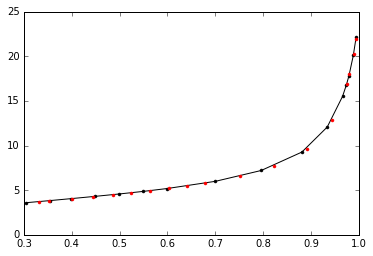

In [15]:
gas_const = get_gas_constant()
radius = np.array([17.3,18.3,20.8,23.5,26.5,29.5,33.3,37.7,42.9,49.3,66.9,98,165.2,325.3,750.9,965.5,1735.5,3192])/2
p_calculate = radius_to_pressure(radius,gas_const)
p_calculate,p_measure
iso_spline = get_spline_fun(p_measure,Q_measure,3)
Q_calculate = iso_spline(p_calculate)

p = p_calculate
Q = Q_calculate
figure = plt.figure()
plt.plot(p_measure,Q_measure,'k.-')
plt.plot(p_calculate,Q_calculate,'r.')


[ 0.          0.00330746  0.00375936  0.00180339  0.00218147  0.00640208
  0.00562806  0.00436971  0.00254612  0.00165767  0.0006482   0.00058069
  0.00055073  0.00055514  0.0005072   0.00014844  0.        ]
0.0346457213317


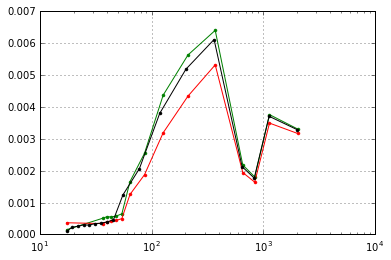

In [5]:
Vp = np.pi*LP*(Davg/2.0)**2 *10**(-16)
#Vp1_cumm = get_cum_Vp(Davg,LP)
print(Vp)
#print(VL[1])
Vp_cumm=np.add.accumulate(Vp)
#print(Vp1_cumm,Vp_cumm)
#print(Davg)
Vp_cum = sum(Vp)
print(Vp_cum)
#residual = Vp_cum -  
figure = plt.figure()
plt.semilogx(Davg[1:],Vp[1:],'g.-')
plt.semilogx(Davg[1:],dV_desorp[1:],'r.-')
plt.semilogx(software_result['D'],software_result['IPV'],'k.-')
plt.grid()


In [6]:
Vp_output=np.array([0.,0.00330746,0.00375936,0.00180339,0.00218147,0.00640208,0.00562806,0.00436971,0.00254612,
     0.00165767,0.0006482,0.00058069,0.00055073,0.00055514,0.0005072,0.00014844,0.])
P_input = [0.30445319,  0.35455676,  0.39906515,  0.44914481,  0.49916705,  0.54897325,
  0.59911312,  0.70041378,  0.79602164,  0.88106023,  0.93408762,  0.96615712,
  0.97399365,  0.97956734,  0.98856465,  0.99454603]
#Vp1 = np.around(Vp1,8)
#Vp = np.around(Vp,8)
print(max(Vp_output-Vp))
#if 
#Vp1-Vp

4.54274594656e-09
